# MIE1613 Project: creating and storing future starts sample paths for input into the simulation
Our simulation function just needs a vector of the starts for each future year. We want to generate a bunch of sample paths for this. I considered two methods in fig_starts_develop.ipynb: a naive time-series method where we fit a smoothed random walk to the data and project simulation paths, and a method where a bayesian model relating population growth to starts is fit, posterior parameters are sampled, and then StatsCan population projections are plugged into the model to generate sample paths. <br>
In this file I store sample paths from one/both of these methods.

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Import
import the population projections and the posterior parameters

In [2]:
rel_path = "data/bayesian_starts_project/"

posteriors = pd.read_csv(rel_path+'pop_housing_linear_posteriors.csv', index_col=0)
projections = pd.read_csv(rel_path+"statscan_population_projection.csv", index_col=0)
projections.index = projections.index.astype(int)
projections = projections *10**3
projections = projections.loc[2023:]

posteriors
projections.head()

,lg3,mg4,mg5,mg6,mg7,mg8,mg9,hg10,sa,fa
year,,,,,,,,,,
2023,39147000.0,39426000.0,39426200.0,39426200.0,39426300.0,39426100.0,39426000.0,39633900.0,39582200.0,39198600.0
2024,39512200.0,39953100.0,39953600.0,39953600.0,39953700.0,39953200.0,39953100.0,40318500.0,40233100.0,39597200.0
2025,39861100.0,40464700.0,40465600.0,40465500.0,40465700.0,40464900.0,40464700.0,40992800.0,40876000.0,39977300.0
2026,40163900.0,40964600.0,40965900.0,40965700.0,40966000.0,40964800.0,40964400.0,41653600.0,41505600.0,40310700.0
2027,40431000.0,41452700.0,41454400.0,41454200.0,41454600.0,41452900.0,41452300.0,42299200.0,42118400.0,40609700.0


## Projection model
create function to spit out the housing starts based on the model $$H = \beta P + c$$

In [3]:
def project_from_pop(beta, c, pv):
    """
    houses = beta*population_vector + c
    """
    h = beta*pv + c

    return h

In [4]:
posteriors['intercept'].values

array([68065.24854196, 74754.68281282, 67155.22541067, ...,
       54994.8857959 , 87495.9869643 , 93974.08025304])

<Axes: xlabel='year', ylabel='lg3'>

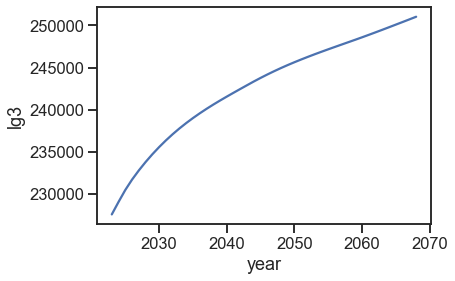

In [5]:
hy = project_from_pop(beta=posteriors['slope'][0], 
                      c=posteriors['intercept'][0],
                      pv=projections['lg3'])

sns.lineplot(hy)

create an efficient matrix function

In [6]:
def project_from_pop(beta, c, p):
    """
    houses = beta(1xn)*population_vector(1xm) + c(1xn)
    """
    # matmul plugin of p values into the linear model
    x = np.column_stack((p,np.ones(len(p))))
    theta = np.column_stack((beta, c))
    y = np.dot(x, theta.T)

    return y.T

<Axes: >

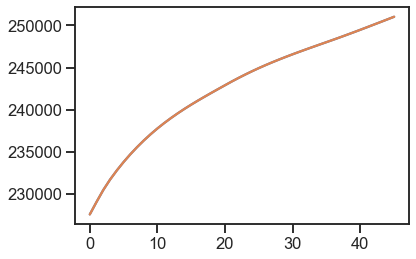

In [7]:
foo2 = project_from_pop(beta=posteriors['slope'][0:3], 
                 c=posteriors['intercept'][0:3],
                 p=projections['lg3'])

fig, ax = plt.subplots()
sns.lineplot(foo2[0],ax=ax)
sns.lineplot(hy.values,ax=ax)

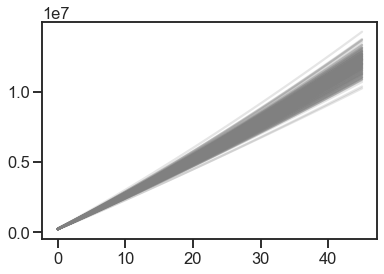

In [8]:
starts_forecast = project_from_pop(beta=posteriors['slope'], 
                                   c=posteriors['intercept'],
                                   p=projections['mg4'])

fig, ax = plt.subplots()

for i in range(200):
    ax.plot(np.cumsum(starts_forecast[i]), color='grey', alpha=0.2)

Plot the cumulative housing growth for all 10 population growth scenarios

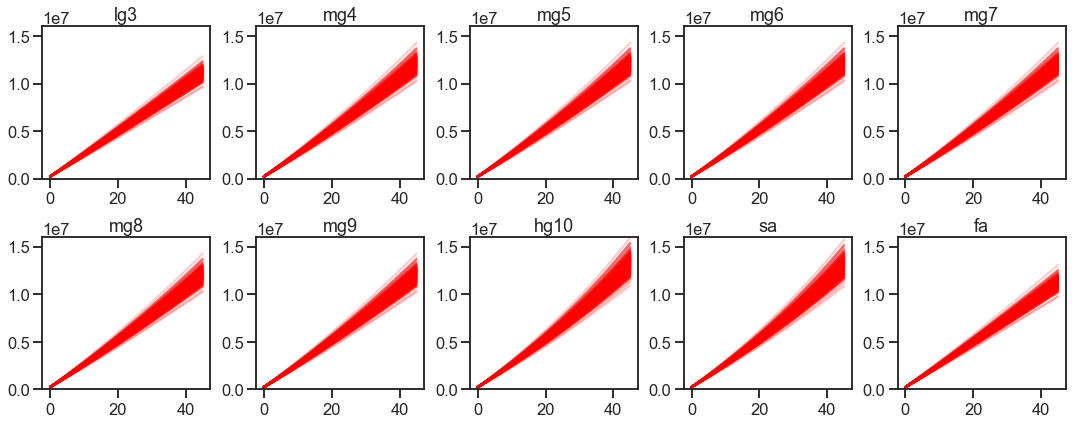

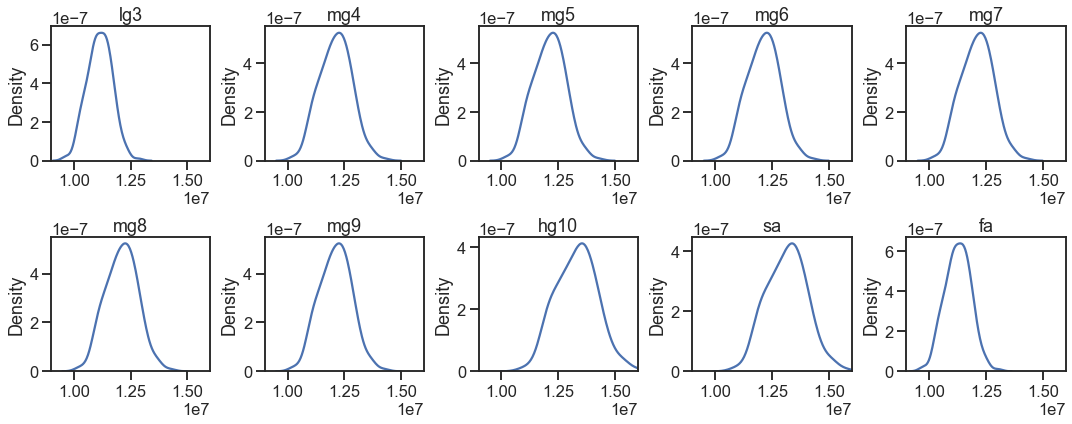

In [9]:
fig, ax = plt.subplots(2,5,figsize=(15,6))
fig2, ax2 = plt.subplots(2,5,figsize=(15,6))

#get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
#cool = get_colors(10)

# loop through projection scenarios from statscan
for k, scenar in enumerate(projections.columns):
    axk = ax.reshape(-1)[k]
    axk2 = ax2.reshape(-1)[k]
    starts_forecast = project_from_pop(beta=posteriors['slope'], 
                                    c=posteriors['intercept'],
                                    p=projections[scenar])

    # plot 200 cumulative samples
    cumu_last = []
    for i in range(200):
        cumu_last.append(np.cumsum(starts_forecast[i])[-1:][0])
        axk.plot(np.cumsum(starts_forecast[i]), color='red', alpha=0.2)
    
    axk.set_ylim([0,1.6*10**7])
    axk.set_title(scenar)

    # plot distribution
    sns.kdeplot(cumu_last, ax=axk2)
    axk2.set_xlim([0.9*10**7,1.6*10**7])
    axk2.set_title(scenar)

    #print('me')

fig.tight_layout()
fig2.tight_layout()

## Save and Export
save some select scenarios: low growth, high growth, maybe a medium one that we are closest to now. export to csv and store in the input data file

In [10]:
projections.columns

Index(['lg3', 'mg4', 'mg5', 'mg6', 'mg7', 'mg8', 'mg9', 'hg10', 'sa', 'fa'], dtype='object')

In [11]:
# save low growth 3, medium growth 6, and high growth 10
for scenar in ['lg3','mg6','hg10']:
    scenario_forecast = project_from_pop(beta=posteriors['slope'], 
                                         c=posteriors['intercept'],
                                         p=projections[scenar])

    pd.DataFrame(scenario_forecast, columns=projections.index).to_csv('starts_samplepaths_bayesian_'+scenar+'.csv')

# these are saved to the input_data file

In [12]:
pd.DataFrame(scenario_forecast, columns=projections.index)

year,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,...,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068
0,229524.226022,232313.121790,235060.057835,237751.998127,240382.017273,242949.707900,245458.736389,247921.731395,250358.246965,252793.947782,...,333187.962426,336899.972101,340695.901223,344575.749791,348538.703053,352585.168385,356714.331035,360926.598380,365221.155667,369596.780769
1,236173.122372,238961.317925,241707.564290,244398.828709,247028.187530,249595.233480,252103.632020,254566.008636,257001.912464,259437.001743,...,339810.831655,343521.909347,347316.885415,351195.759859,355157.718132,359203.167508,363331.293439,367542.503199,371835.982240,376210.508743
2,229234.814042,232034.429684,234791.924319,237494.211809,240134.340144,242711.900382,245230.572999,247703.035192,250148.916166,252593.979257,...,333297.009991,337023.287778,340833.807578,344728.569390,348706.755333,352768.774346,356913.808548,361142.266879,365453.331456,369845.775453
3,229234.814042,232034.429684,234791.924319,237494.211809,240134.340144,242711.900382,245230.572999,247703.035192,250148.916166,252593.979257,...,333297.009991,337023.287778,340833.807578,344728.569390,348706.755333,352768.774346,356913.808548,361142.266879,365453.331456,369845.775453
4,221825.769749,224328.577518,226793.729839,229209.527931,231569.756818,233874.050912,236125.700496,238336.038762,240522.613882,242708.457828,...,314855.565924,318186.793559,321593.332092,325075.181521,328631.610674,332262.985137,335968.573736,339748.742058,343602.758930,347529.527590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,224614.690579,226886.280928,229123.694560,231316.313466,233458.496828,235549.912833,237593.547797,239599.687915,241584.260202,243568.168864,...,309050.095401,312073.573528,315165.405091,318325.590087,321553.464893,324849.361320,328212.615743,331643.559975,335141.530390,338705.531550
5996,222712.229317,225028.705617,227310.329878,229546.274281,231730.786550,233863.528314,235947.544898,237993.325749,240017.112595,242040.222703,...,308816.052657,311899.273814,315052.199050,318274.828363,321566.485016,324927.507377,328357.218709,331855.957380,335423.046651,339057.471415
5997,241836.650346,245063.985330,248242.764149,251357.901393,254401.382938,257372.737364,260276.207444,263126.407168,265945.964652,268764.579298,...,361797.247966,366092.818572,370485.501508,374975.296773,379561.261529,384243.867196,389022.170934,393896.644164,398866.344047,403929.856326
5998,222341.097203,224670.289195,226964.437836,229212.655873,231409.159451,233553.608344,235649.064592,237706.075224,239740.971119,241775.186561,...,308917.564993,312017.710688,315187.943083,318428.262178,321737.987520,325117.459336,328565.997172,332083.941255,335670.611131,339324.986121
